---
title: "Adam optimizer with annealing learning rate"
author: "Alex Kelly"
date: "2023-12-28"
format:
  html:
    code-fold: True
    toc : true
    numbered-sections : true
jupyter : python3
draft : True
---

# Overview

The aim of this blog is to explain the role of a optimizer in a neural network training loop.  I will explain what a neural network is, what a optimizer is and go deeper into maths of a optimizer to gain a more intuative understanding.  All the code to run the models and charts are included in this blog post.

## Neural Networks

A neural network, inspired by the human brain, is a form of machine learning model. The human brain comprises neurons interconnected by synapses, with electrical pulses transmitting information. In a similar manner, a neural network processes input, like reading a book, by activating relevant neurons involved in text interpretation, akin to the thinking process, before producing an output, such as a summary of the text. An artificial neural network (ANN) consists of artificial neurons organized in a specific architecture within a computer. Examples of ANN architectures include Convolutional Neural Networks (CNNs) and Recurrent Neural Networks (RNNs), or a hybrid of these and other layers. For instance, in image processing, the model receives a sequence of pixels (an image) and employs sequential CNNs to generate a corresponding sequence of pixels as an output.


In [ ]:
# !["Human neural network vs artificial neural network"]("https://clevertap.com/wp-content/uploads/2019/04/Neural_Network_Brain_Mimic.jpeg")

# Neural Network architecture

The aim of this neural network to understand our image training data.  For this, our model leverages a Convolutional Neural Network (CNN) architecture, intricately designed through five principal blocks. Each block is a structured sequence of layers, purposefully arranged to process and extract features from the input data.

- Initial Block: It commences with a 'Conv2d' layer, configured for one input channel and eight output channels. This layer is complemented by a 'BatchNorm2d' layer for normalization, and a 'GeneralRelu' layer, a versatile version of the standard ReLU activation function.
- Second Block: Mirroring the first, this block begins with an enhanced 'Conv2d' layer, now accommodating eight input channels and escalating to 16 output channels, maintaining the sequence with 'BatchNorm2d' and 'GeneralRelu'.
- Mid-Level Block: The third block further scales up, starting with a 'Conv2d' layer with 16 input channels, doubling the output channels to 32. It follows the established pattern of incorporating 'BatchNorm2d' and 'GeneralRelu'.
- Penultimate Block: This block intensifies feature extraction, starting with a 'Conv2d' layer having 32 input channels and 64 output channels, and like its predecessors, includes 'BatchNorm2d' and 'GeneralRelu'.
- Final Block: A distinct departure from the previous blocks, this solely contains a 'Conv2d' layer, taking in 64 input channels and narrowing down to 10 output channels.

The architecture culminates with a 'Flatten' layer. This crucial layer transforms the 2D output from the convolutional blocks into a 1D vector, essential for subsequent processing or generating the final output.

Throughout this architecture, the convolutional layers systematically compress the image, distilling it into increasingly compact forms. This process enables the model to discern and learn vital features of the image. In the final stage, the model utilizes these learned features to make informed predictions.

## What is an optimizer in deep learning and why it is important?

An optimizer is a method to update the weights of the neural network to minimize the loss function.  A loss function is a measure between the predicted output and the actual output. In simple terms the closer these two are the better the model will perform, you will get what you expect from the model.  The weights are updated by using the gradient of the loss function.  The gradient is the slope of the loss function.  It can be thought of as the direction the weights should be updated.  If the gradient is positive then the weights should be increased.  If the gradient is negative then the weights should be decreased.  If the weights are increased/descreased by too much then the model will over shoot.  This pattern can continue forever and not get you closer to your desired result, a smaller loss.  The aim of the optimizer is to get to the smallest loss possible in the quickest amount of time or with the least amount of resources.

## Adam optimizer with annealing learning rate

The aim of this blog is to show how to use the Adam optimizer with annealing learning rate. The Adam optimizer is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments. The Adam optimizer is one of the most popular optimizers used in deep learning. The annealing learning rate is used to prevent the model from overfitting and is also used to speed up the training process.

# The intial code: importing libraries , setting up enviorment and the data

## Setup enviroment

In [ ]:
#| echo: True
#| output: True
import os
import sys

In [ ]:
#| echo: True
#| output: True

# checks if the environment is local or remote
def check_if_local():
    # Checking for common remote environment indicators
    remote_indicators = ['COLAB_GPU', 'JUPYTERHUB_SERVICE_PREFIX']

    # If any of the indicators are present, it's likely not a local environment
    if any(indicator in os.environ for indicator in remote_indicators):
        return False
    else:
        # Assuming local environment if none of the remote indicators are found
        return True


In [ ]:
#| echo: True
#| output: False

# checks if the environment is local or remote and sets the path accordingly
if check_if_local() == False:
    print('Running in a remote environment, mounting Google Drive...')
    from google.colab import drive
    drive.mount('/content/drive')
    sys.path.append('/content/drive/MyDrive/Learning/data_science/')
    !pip install datasets
    !pip install torcheval
else :
    print('Running in a local environment...')
    sys.path.append('G:\My Drive\Learning\data_science')


Running in a remote environment, mounting Google Drive...
Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 3.2 MB/s eta 0:00:00


In [ ]:
#| echo: False
#| output: True

# checks if the environment is local or remote and sets the path accordingly
if check_if_local() == False:
    print('Running in a remote environment, mounting Google Drive...')
else :
    print('Running in a local environment...')

Running in a remote environment, mounting Google Drive...


In [ ]:
#| echo: True
#| output: False
import os
import sys
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
import fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *

## Get the data

In [ ]:
#| echo: True
#| output: False

from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)

import logging
logging.disable(logging.WARNING)

set_seed(42)
xl,yl = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

bs = 1024
xmean,xstd = 0.28, 0.35

@inplace
def transformi(b): b[xl] = [(TF.to_tensor(o)-xmean)/xstd for o in b[xl]]

tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=0)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

## Setup the call backs

In [ ]:
#| echo: True
#| output: True

metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(fc.risinstance(GeneralRelu))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
iw = partial(init_weights, leaky=0.1)
lrf_cbs = [DeviceCB(), LRFinderCB()]

# The MiniAI learner class and the optimizer role


We are using the MiniAI custom trainer class from Fast AI.  It enables you to train deep learning neural network models.  Its very dynanamic and enables you to add callbacks (custom peices of code) to various parts of the training process. This creates a flexible system where you can add, swap and experiment in a quick, easy and repeatably way. In summary its very flexiable trainer class to enable effective training of neurual networks.

The mini AI learner class takes in :

- The Model (The architecture)
- The Data (images you want to learn on)
- The Optimizer class (How to minimize the loss)
- The Loss function (How to calculate the loss)
- The Number of epochs (How many times to train the model on the data e.g. how many passes through the data)
- The Learning rate  (How quickly to reduce the learning rate)
- Any Call backs (custom peices of code to change the learner)

For the next few trainings runs we will use a varient of the learner class called TrainLeaner, the only difference between Learner and TrainLearner is the Learner expect you you pass the functons listed below as callbacks whereas TrainLearer  explicitly adds the following functions to the learner object.

1. predict
2. get_loss
3. backward
4. step
5. zero_grad

The first step is to create an instance of the TrainLearner class and next step is to call the fit method to start the training. In summary it will:

1. Pass the first batch of data to the model
2. Calculate the loss on the model
3. Perform back propergation to figure out the gradient
4. Run the opimizer (e.g. SGD or ADAM) to figure out how to reduce the loss in the most optimized way
5. Zero's the gradients for all the parameters (Most models accumilates the gradients so zero'ing is important to get the correct result)
6. Repeat 1 to 5 until until you've been through the data as many times as specified in the epochs parameter in the hope that the model has learned the features of the data and can give a good prediction.

Somestimes a diagram is better to understand so I've included a flow diagram of the learner method when fit is called is shown below.

```{mermaid}
flowchart TD
    A(fit called) --> B[fit]
    B -->|Set epochs, opt func, etc.| C[_fit]
    C -->|For each epoch| D[one_epoch for Training]
    C -->|For each epoch| E[one_epoch for Validation]
    D --> F{_one_batch for each batch in Training}
    E --> G{_one_batch for each batch in Validation}
    F --> H[predict]
    G --> H
    H --> I[get_loss]
    I -->|If Training| J[backward]
    I -->|If Validation| K(End of batch processing)
    J --> L[step]
    L --> M[zero_grad]
    M --> K

    subgraph SGD Optimizer
        L -->|opt_step| N(Update params with lr and gradient)
        L -->|reg_step| O(Update params with weight decay)
        M --> P(Reset gradients)
    end

    subgraph TrainLearner Methods
        H --> Q(Predict: Model forward pass)
        I --> R(Calculate Loss)
        J --> S(Backward: Compute gradient)
        L --> T(Step: Update weights)
        M --> U(Zero_grad: Clear gradients)
    end
```

The learner class is shown

In [ ]:
#| echo: True
#| output: True

# The learner class expects the following fucntions to be passed as a callback : predict, get_loss, backward, step, zero_grad.
class Learner():
    def __init__(self, model, dls=(0,), loss_func=F.mse_loss, lr=0.1, cbs=None, opt_func=optim.SGD):
        cbs = fc.L(cbs)
        fc.store_attr()

    @with_cbs('batch')
    def _one_batch(self):
        self.predict()
        self.callback('after_predict')
        self.get_loss()
        self.callback('after_loss')
        if self.training:
            self.backward()
            self.callback('after_backward')
            self.step()
            self.callback('after_step')
            self.zero_grad()

    @with_cbs('epoch')
    def _one_epoch(self):
        for self.iter,self.batch in enumerate(self.dl): self._one_batch()

    def one_epoch(self, training):
        self.model.train(training)
        self.dl = self.dls.train if training else self.dls.valid
        self._one_epoch()

    @with_cbs('fit')
    def _fit(self, train, valid):
        for self.epoch in self.epochs:
            if train: self.one_epoch(True)
            if valid: torch.no_grad()(self.one_epoch)(False)

    def fit(self, n_epochs=1, train=True, valid=True, cbs=None, lr=None):
        cbs = fc.L(cbs)
        # `add_cb` and `rm_cb` were added in lesson 18
        for cb in cbs: self.cbs.append(cb)
        try:
            self.n_epochs = n_epochs
            self.epochs = range(n_epochs)
            if lr is None: lr = self.lr
            if self.opt_func: self.opt = self.opt_func(self.model.parameters(), lr)
            self._fit(train, valid)
        finally:
            for cb in cbs: self.cbs.remove(cb)

    def __getattr__(self, name):
        if name in ('predict','get_loss','backward','step','zero_grad'): return partial(self.callback, name)
        raise AttributeError(name)

    def callback(self, method_nm): run_cbs(self.cbs, method_nm, self)

    @property
    def training(self): return self.model.training

In [ ]:
#| echo: True
#| output: True

# The Trainer class inherits all the classes from Leaner but explicitly adds
# predict, get_loss, backward, step, zero_grad classes functions

class TrainLearner(Learner):
    def predict(self): self.preds = self.model(self.batch[0])
    def get_loss(self): self.loss = self.loss_func(self.preds, self.batch[1])
    def backward(self): self.loss.backward()
    def step(self): self.opt.step()
    def zero_grad(self): self.opt.zero_grad()

# The optimizers



## Overview of optimizers


We will start of with one of the simplest optimizers and build up, taking in the results and how they improve as we introduce more sophisticated optimisers.  We will cover SGD, Adam, Adam with Automatic Annealer, and then introduce Adam with Automatic Annealing as a call back.  Abit about each of the optimizers:

- **SGD** is a simple optimizer that takes in the learning rate and the model parameters and updates the model parameters every time a backwards pass (every epoch) by subtracting the learning rate multiplied by the gradient of the loss function.  Its beauty is that its a simple optimizer that only takes in learning rate making it low resource and simple to understand. The learning rate is a hyperparameter that needs to be tuned to get the best results.  If the learning rate is too high then the model will overshoot and not get to the minimum loss.  If the learning rate is too low then the model will take a long time to get to the minimum loss.  The learning rate is a constant and does not change during the training process.

- **Adam** is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.  It is one of the most popular optimizers used in deep learning.  It is a adaptive learning rate optimizer that uses the first and second moments of the gradient to update the model parameters.  The first moment is the mean of the gradient and the second moment is the uncentered variance of the gradient.  The first moment is used to calculate the direction of the gradient and the second moment is used to calculate the size of the gradient.  The Adam optimizer has three hyperparameters that need to be tuned to get the best results.  The first hyperparameter is the learning rate.  The second hyperparameter is the beta1 which is the exponential decay rate for the first moment.  The third hyperparameter is the beta2 which is the exponential decay rate for the second moment.  The learning rate is a constant and does not change during the training process.  The beta1 and beta2 are constants and do not change during the training process.  Adam is more resource intensive than SGD as it needs to keep a copy of the beta1 parameters and beta2 parameters in memory and also has more operations to calculate the results.

- **Adam with Automatic Annealing** is a Adam optimizer that uses a learning rate that changes during the training process.  The learning rate is a hyperparameter that needs to be tuned to get the best results.  If the learning rate is too high then the model will overshoot and not get to the minimum loss.  If the learning rate is too low then the model will take a long time to get to the minimum loss.  The learning rate is a constant and does not change during the training process.

## The SGD optimizer

The SGD optimizer class is a simple class that takes in params, learning rate (lr), and weight decay.  It has 4 functions :

- Step
- Opt_step
- Reg_step
- Zero_grad  

The key function we're intersted in relating to TrainLearner is the step function which calls opt_step (updates the parameters from the learning rate),  reg_step isnt used (updates parameters from the weight decay if given).

Zero_grad is called after every batch to zero the gradients, by default in pytorch they acculmtate which isnt desired.

In [ ]:
#| echo: True
#| output: True

# SGD optimizer is a type of gradient descent optimizer.  It is a first order optimizer (only uses the first derivative)
# It is a stochastic optimizer (it uses a random sample of the data to calculate the gradient)

class SGD:
    def __init__(self, params, lr, wd=0.):
        """
        Initializes the SGD  optimizer.

        Args:
            params (iterable): Iterable of parameters to optimize.
            lr (float): Learning rate.
            wd (float, optional): Weight decay (default: 0).

        """
        params = list(params)
        fc.store_attr()
        self.i = 0
    # calculates the parameters and weight decays. Step occurs after the backward pass (when the gradients are calculated)
    def step(self):
        # calls torch.no_grad() to disable gradient tracking
        with torch.no_grad():
            # iterates over the parameters
            for p in self.params:
                self.reg_step(p)
                self.opt_step(p)
        self.i +=1

    # Updates the parameters using the gradient and the learning rate
    def opt_step(self, p): p -= p.grad * self.lr

    # Calculates the weight decay and updates the parameters
    # The purpose of weight decay is to prevent overfitting. It is calculated by multiplying the learning rate by the weight decay
    # essentially it is a penalty for having large weights (it reduces the value of the weights)
    def reg_step(self, p):
        if self.wd != 0: p *= 1 - self.lr*self.wd

    # Zeros out the gradient for all parameters.  This is useful because the gradients are accumulated by default (useful for RNNs)
    def zero_grad(self):
        for p in self.params: p.grad.data.zero_()

accuracy,loss,epoch,train
0.396,1.808,0,train
0.558,1.467,0,eval
0.611,1.304,1,train
0.644,1.179,1,eval
0.672,1.093,2,train
0.688,1.029,2,eval


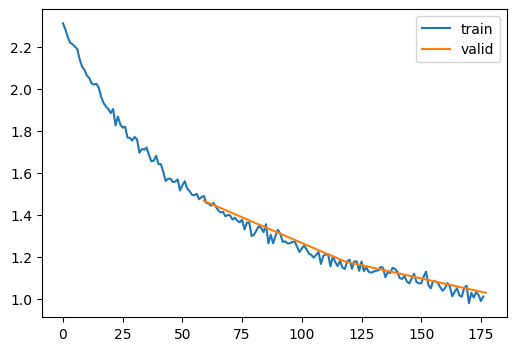

In [ ]:
#| echo: True
#| output: True

set_seed(42)                                             # sets the seed for reproducibility
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw) # gets the model and applies the init_weights function

# creates the learner object and passes the model, dataloaders (the data), loss function, learning rate,
# callbacks and optimizer function
learn = TrainLearner(model, dls, F.cross_entropy, lr=6e-3, cbs=cbs, opt_func=SGD)
learn.fit(3)                                             # fits the model for 3 epochs

## Adam Optimizer

Adam optimizer (also known as Adaptive Moment Estimation) is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments. It's a combination of RMSprop and Momentum and commonly used in deep learning.  It's a little more complex than the SGD discussed above.  There are some learning utilities and also numbered code explanations to help understand the code further.



For a deeper dive deeper, the following resources are good references.

- https://www.mathsisfun.com/calculus/second-derivative.html
- https://www.mathsisfun.com/calculus/second-derivative-animation.html

The Adam optimizer below inherits all the code from SGD and replaces **opt_step** with new code to update the parameters.  The important variables opt_step takes in for our case are :


- **Params** (also known as p in opt_step) also known as the weights and bias's
- **Beta1** which really should be called something like "momentum_decay_rate", it is akin to momentum in physics and helps to accelerate the optimizer in the direction of consistent and persistent gradients over time.
- **Beta2** which should really be called something like "variance_decay_rate".  It is used for adaptive learning rate purposes, helping to adjust the learning rate based on the variability of the gradients


A intuative way to think about beta1 ("momentum_decay_rate") and beta2 ("variance_decay_rate") is : <br>

- Beta1 is the compass<br>
- Beta2 is the distance to travel

The reason for this will be become clearer

In [ ]:
#| echo: True
#| output: True

class Adam(SGD):
    def __init__(self, params, lr, wd=0., beta1=0.9, beta2=0.99, eps=1e-5):
        super().__init__(params, lr=lr, wd=wd)
        self.beta1,self.beta2,self.eps = beta1,beta2,eps

    def opt_step(self, p):
        if not hasattr(p, 'avg'): p.avg = torch.zeros_like(p.grad.data)  # <1>
        if not hasattr(p, 'sqr_avg'): p.sqr_avg = torch.zeros_like(p.grad.data) # <2>

        # Beta 1 calculations
        p.avg = self.beta1*p.avg + (1-self.beta1)*p.grad  # <3>
        unbias_avg = p.avg / (1 - (self.beta1**(self.i+1)))  # <4>

        # Beta 2 calculations
        p.sqr_avg = self.beta2*p.sqr_avg + (1-self.beta2)*(p.grad**2)  # <5>
        unbias_sqr_avg = p.sqr_avg / (1 - (self.beta2**(self.i+1)))  # <6>

        # Combination of beta1 and beta2 combinations
        p -= self.lr * unbias_avg / (unbias_sqr_avg + self.eps).sqrt()  # <7>

NameError: ignored

1. Checks avg tensor doesnt exist in p, if doesnt existit creates a matching size tensor of all parameters to store averages, they will all be zeros.
2. Checks sqr_avg doesnt exist in p, if it doesnt exist it creates a matching sized tensor of all parameters to store sqr averages, they will all be zeros.
3. p.avg is to store the averages, it can be thought of as a balance between the old gradients and the new gradiants<br>
Beta is set between 1 or 0, when its closer to 1 it takes more of the historical gradients into account and when close to 0, it takes more of the  new gradients into account.<br>
When its closer to 1, it will be a smoother path and when its zero it will respond to changes in gradients much quicker and appear more erratic.<br>
Note, on the first run the calculation of p.avg is solely based on the latter part of the equation "(1 - self.beta1) * p.grad".<br>
The first part of the equation "self.beta1 * p.avg" is zero meaning due to p.avg being set to zeros in the line "p.avg = torch.zeros_like(p.grad.data)".<br>
The next time opt_step is called, The first part of the equation will influence the result "self.beta1 * p.avg".<br>
4. Unbias_avg purpose is to correct p.avg for the earier few times called when p.avg is initialised as zero as described in point 1. Something is required to reduce the depency on p.avg during the early calls,  this is where unbias comes into play and will be more significant for the early iterations and gradually becomes less significant for later iterations.
5. Squaring the gradients (p.grad**2) emphasizes larger gradients and diminishes the impact of smaller ones.  We dont want this but will become clearer on point 7.
6. unbias_sqr_avg purpose is to correct p.sqr_avg for the first few times called. Remember that in the previous step, the p.sqr_avg is zero so isnt included in the calculations.<br>
The unbias will  is more significant for the early iterations and gradually becomes less significant for later iterations.
7. The final peice is to update the parameters (weights and bias's). The second part of the equation is to "(unbias_sqr_avg + self.eps).sqrt()" is to get the distance (the 2nd momentum), unbias_sqr_avg will lead to overshooting so square root the value to get a smoother line.  The 1st part of equation is 1st moment (the direction of travel) and its to get at the average direction of the travel taking into a account the learning rate, following on from the anology of the compass, this means the more epoch's (one pass through the dat) through the data, the less the direction changes.

### Deeper dive into the maths and charts

I wanted to dive a bit deeper into the maths, it didnt make intuative sense until I started to plot the results in various ways.  The 2 charts below really helped me understand whats going on.  As mentioned below, I've kept hearing that you can think of the first moment as a compass and the second moment as a distance to travel but i didnt understand what it meant, hopefully you understand after you have read this.

**Note, the 2 illistrates below are using randomized data to illistrate points**

The chart below shows the calculations for beta1 and beta2 in a flow chart style which shows that beta1 and beta 2 are really calculated in pararel.

```{mermaid}
graph TD
    A[beta calculations]

    A --> D1[Beta 1 - the compass]
    D1 --> E1["p.avg = self.beta1*p.avg + (1-self.beta1)*p.grad"]
    E1 --> F1["unbias_avg = p.avg / (1 - (self.beta1**(self.i+1)))"]
    F1 --> G[End of Parallel Calculations]

    A --> D2[Beta 2 - The distance to travel]
    D2 --> E2["p.sqr_avg = self.beta2*p.sqr_avg + (1-self.beta2)*(p.grad**2)"]
    E2 --> F2["unbias_sqr_avg = p.sqr_avg / (1 - (self.beta2**(self.i+1)))"]
    F2 --> G

    G --> H[Combine of Beta 1 and Beta 2 along with learning rate]
    H --> I["p -= self.lr * unbias_avg / (unbias_sqr_avg + self.eps).sqrt()"]
    I --> J[Update Parameter p]
    J --> K[End]
```


### The compass - The first momentum

The first momentum (the compass) tells you the direction which is either negative or posotive, do you want to negativly update the paremeters or positivly.<br>
I've plotted beta1 results from 0.1 to 0.9 with the lower betas more swayed to the most recent calculated gradients (aka the most recent backward pass) to and ligher colours plotted to more to the older averaged gradients (historical gradients).  <br>
- The darker colours (lower beta1) swing more wildley going from negative to positve from itteration to itteration.
- The lighter colours (higher beta1) have a much smoother line and stay positive or negative for more itterations.

There's 2 important take aways.

1. The higher beta1 is, the smoother shorter the path.
2. The result from this part of the equation can be negative and positive.  It fits the compass anology, it tells you the direction to update the weights and bias's (parameters).  This is key to understand the relationship with beta2 part of the equation.

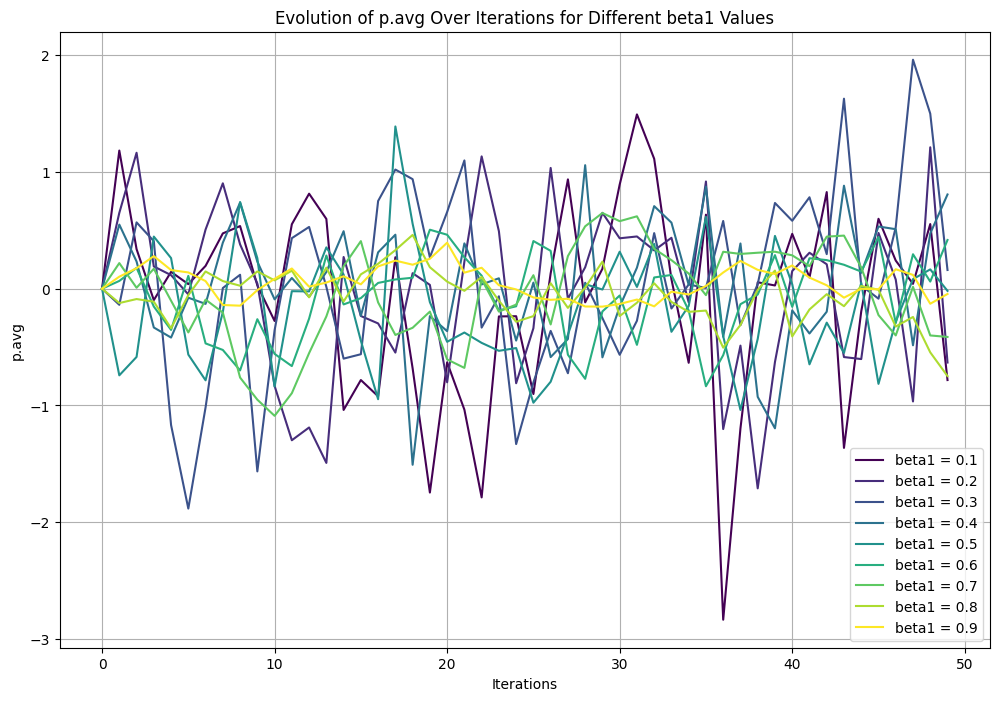

In [ ]:
# Setting up an updated simulation with a wider range of beta1 values

iterations = 50

# New range of beta1 values
beta1_values = np.arange(0.1, 1.0, 0.1)

# Initialize a dictionary to store p.avg values for each beta1 across iterations
p_avg_values = {beta1: [0] for beta1 in beta1_values}  # Start with 0

# Simulate p.avg updates over iterations
for beta1 in beta1_values:
    for i in range(1, iterations):
        # Simulate a random gradient at each step
        p_grad = np.random.randn()

        # Update p.avg using the formula: beta1*p.avg + (1-beta1)*p.grad
        new_p_avg = beta1 * p_avg_values[beta1][-1] + (1 - beta1) * p_grad
        p_avg_values[beta1].append(new_p_avg)

# Plotting with relevant colors
plt.figure(figsize=(12, 8))
# Generate a color map to assign a unique color to each beta1 value
colors = plt.cm.viridis(np.linspace(0, 1, len(beta1_values)))

for beta1, color in zip(beta1_values, colors):
    plt.plot(p_avg_values[beta1], label=f'beta1 = {beta1:.1f}', color=color)

plt.xlabel('Iterations')
plt.ylabel('p.avg')
plt.title('Evolution of p.avg Over Iterations for Different beta1 Values')
plt.legend()
plt.grid(True)
plt.show()


The second momentum (the distance to travel) tells you the distance, that is how much to change the parameters and only the distance, not the direction (Beta2 is always positive).<br>

To get to this result:

- We first square the gradients which will turn the results positive, this has the effect of making any large number that is either negative or positive into a even larger positive number.  Smaller numbers that are either negative or positive will also become positive but to a lesser degree.

- Then we will square root the previously squared number to scaled the number down.  

The graphs below dispicts the operations mentioned above visually.
- The left chart shows how squaring (Green) the results increases the magnitude positively<br>
- The right chart shows how smooth the line looks when square rooting (blue) the previously squared values.<br>
- The original gradients (marked in red) jump up and down over time over epochs (iterations).

The blue line shows a steady path (line in this case) to minimize the loss is key to getting to a loss function in the most predictable way.  If you was to measure the red line, it would be much shorter than the blue (the gradient).

<Figure size 1200x600 with 0 Axes>

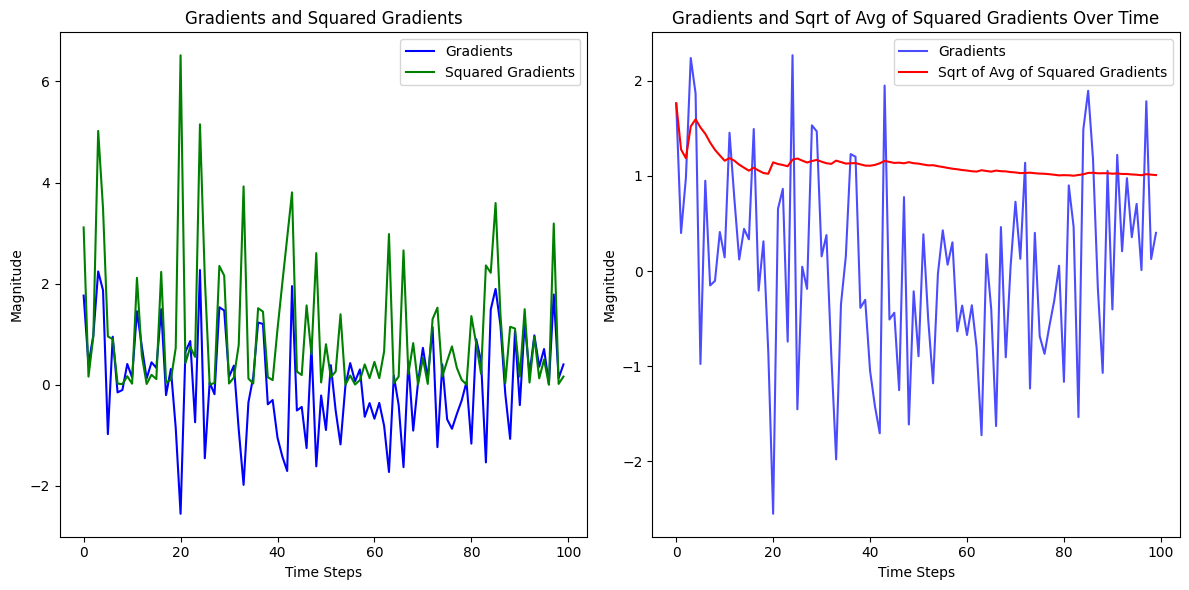

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Simulate some gradients
np.random.seed(0)
gradients = np.random.randn(100)  # Random gradients for simulation

# Compute squared gradients
squared_gradients = gradients**2

# Compute square root of the average of squared gradients (simulating the second moment in Adam)
sqrt_avg_squared_gradients = np.sqrt(np.cumsum(squared_gradients) / np.arange(1, 101))

# Plotting
plt.figure(figsize=(12, 6))

# Updating the plot with distinct colors for each curve

# Plotting with distinct colors
plt.figure(figsize=(12, 6))

# Plot for Gradients and Squared Gradients
plt.subplot(1, 2, 1)
plt.plot(gradients, label='Gradients', color='blue')
plt.plot(squared_gradients, label='Squared Gradients', color='green')
plt.title('Gradients and Squared Gradients')
plt.xlabel('Time Steps')
plt.ylabel('Magnitude')
plt.legend()

# Plot for Gradients and Square Root of Avg of Squared Gradients
plt.subplot(1, 2, 2)
plt.plot(gradients, label='Gradients', color='blue', alpha=0.7)
plt.plot(sqrt_avg_squared_gradients, label='Sqrt of Avg of Squared Gradients', color='red')
plt.title('Gradients and Sqrt of Avg of Squared Gradients Over Time')
plt.xlabel('Time Steps')
plt.ylabel('Magnitude')
plt.legend()

plt.tight_layout()
plt.show()

Now bringing the compass aka direction (aka BETA1) and distance (aka BETA2) together.  

The way I like to think of it, is we have the compass being positve or negative and we divide by the distance which is always positve.  So the compass will either be pointing up or down at different magnatudes and the distance will either be long (a high number) or short (a low number).

accuracy,loss,epoch,train
0.796,0.574,0,train
0.843,0.433,0,eval
0.868,0.363,1,train
0.867,0.373,1,eval
0.884,0.318,2,train
0.875,0.349,2,eval


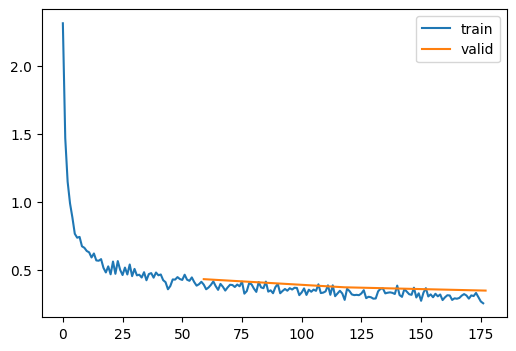

In [ ]:
#| echo: True
#| output: True

# first run with adam as the optimizer
set_seed(42)                                                # sets the seed for reproducibility
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)    # gets the model and applies the init_weights function

# creates the learner object and passes the model, dataloaders (the data), loss function, learning rate,
# callbacks and optimizer function
learn = TrainLearner(model, dls, F.cross_entropy, lr=6e-3, cbs=cbs, opt_func=Adam)
learn.fit(3)                                                # fits the model for 3 epochs

## Adam with Automatic Annealer

Adam optimizer (also known as Adaptive Moment Estimation) with annealing is the same as vanlila Adam (i.e. adaptive estimation of first-order and second-order moments). However it also has a extra parameter.

If the validation loss plateaus or increases, the annealer may reduce the learning rate, effectively "cooling down" the optimization and allowing the model to escape local minima or saddle points. Conversely, if the model is learning effectively, the annealer might maintain or even slightly increase the learning rate.

The only change in the opt_step is that is the line below to include the annealing rate.  
-  "annealed_lr = self.lr * (self.anneal_rate ** self.i)"

In [ ]:
#| echo: True
#| output: True

# Run with adam with annealing as the optimizer
class AdamWithAnnealing(SGD):
    def __init__(self, params, lr, wd=0., beta1=0.9, beta2=0.99, eps=1e-5, anneal_rate=0.97):
        super().__init__(params, lr=lr, wd=wd)
        self.beta1, self.beta2, self.eps = beta1, beta2, eps
        self.anneal_rate = anneal_rate

    def opt_step(self, p):
        if not hasattr(p, 'avg'): p.avg = torch.zeros_like(p.grad.data)
        if not hasattr(p, 'sqr_avg'): p.sqr_avg = torch.zeros_like(p.grad.data)

        # Update averages
        p.avg = self.beta1 * p.avg + (1 - self.beta1) * p.grad
        unbias_avg = p.avg / (1 - (self.beta1**(self.i + 1)))
        p.sqr_avg = self.beta2 * p.sqr_avg + (1 - self.beta2) * (p.grad**2)
        unbias_sqr_avg = p.sqr_avg / (1 - (self.beta2**(self.i + 1)))

        # Apply annealing to learning rate
        annealed_lr = self.lr * (self.anneal_rate ** self.i)

        # Update parameters
        p -= annealed_lr * unbias_avg / (unbias_sqr_avg.sqrt() + self.eps)


In [ ]:
#| echo: True
#| output: True

metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(fc.risinstance(GeneralRelu))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
iw = partial(init_weights, leaky=0.1)
lrf_cbs = [DeviceCB(), LRFinderCB()]

accuracy,loss,epoch,train
0.793,0.580,0,train
0.835,0.452,0,eval
0.854,0.406,1,train
0.845,0.430,1,eval
0.859,0.392,2,train
0.846,0.427,2,eval


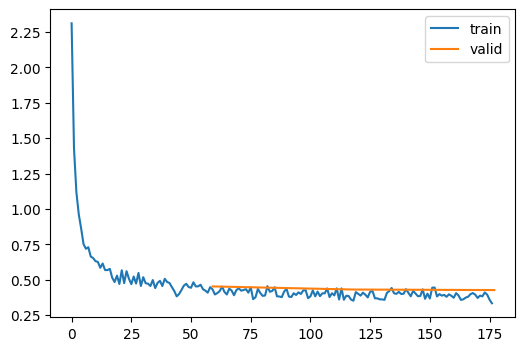

In [ ]:
#| echo: True
#| output: True

set_seed(42)                                               # sets the seed for reproducibility
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)   # gets the model and applies the init_weights function

# creates the learner object and passes the model, dataloaders (the data), loss function, learning rate,
# callbacks and optimizer function
learn = TrainLearner(model, dls, F.cross_entropy, lr=6e-3, cbs=cbs, opt_func=AdamWithAnnealing)
learn.fit(3)                                               # fits the model for 3 epochs

# The Calls backs

To create a call back, i will demostrate it on the simplest of optimizers, the SGD optimizer and repeat the process on the Adam with annealing.

We will create a callbackclass from TrainCB which has the following methods:

- predict
- get_loss
- backward
- step
- zero_grad

We will be replacing step, and adding opt_step and reg_step.  The step function is called after the backward function and before the zero_grad function.  The step function is used to update the model parameters.  The opt_step function is used to update the model parameters from the learning rate.  The reg_step function is used to update the model parameters from the weight decay if given.  The zero_grad function is used to zero the gradients.

## SGD

In [ ]:
#| echo: True
#| output: True
class SGDCallback_TrainCB(TrainCB):
    def __init__(self, lr, wd=0., n_inp=1):
        self.n_inp = n_inp
        fc.store_attr()
        self.i = 0
        # calculates the parameters and weight decays. Step occurs after the backward pass (when the gradients are calculated)
    def step(self, learn):
        # calls torch.no_grad() to disable gradient tracking
        with torch.no_grad():
            # iterates over the parameters
            for p in learn.model.parameters():
                self.reg_step(p)
                self.opt_step(p)
        self.i +=1
    # Updates the parameters using the gradient and the learning rate
    def opt_step(self, p): p -= p.grad * self.lr

    # Calculates the weight decay and updates the parameters
    # The purpose of weight decay is to prevent overfitting. It is calculated by multiplying the learning rate by the weight decay
    # essentially it is a penalty for having large weights (it reduces the value of the weights)
    def reg_step(self, p):
        if self.wd != 0: p *= 1 - self.lr*self.wd
    def zero_grad(self, learn): learn.opt.zero_grad()

In [ ]:
#| echo: True
#| output: True

# SGDCallback_TrainCB added to callbacks and no optimizer function passed

metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(fc.risinstance(GeneralRelu))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats, SGDCallback_TrainCB(lr=6e-3)]
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
iw = partial(init_weights, leaky=0.1)

method is  <bound method DeviceCB.before_fit of <miniai.learner.DeviceCB object at 0x0000025314BA9EE0>>
learn in  <__main__.Learner object at 0x0000025446BD2A60>
method is  <bound method MetricsCB.before_fit of <miniai.learner.MetricsCB object at 0x0000025314B97F10>>
learn in  <__main__.Learner object at 0x0000025446BD2A60>
method is  <bound method HooksCallback.before_fit of <miniai.activations.ActivationStats object at 0x000002537D6BC910>>
learn in  <__main__.Learner object at 0x0000025446BD2A60>
method is  <bound method ProgressCB.before_fit of <miniai.learner.ProgressCB object at 0x0000025314384670>>
learn in  <__main__.Learner object at 0x0000025446BD2A60>


method is  <bound method MetricsCB.before_epoch of <miniai.learner.MetricsCB object at 0x0000025314B97F10>>
learn in  <__main__.Learner object at 0x0000025446BD2A60>
method is  <bound method ProgressCB.before_epoch of <miniai.learner.ProgressCB object at 0x0000025314384670>>
learn in  <__main__.Learner object at 0x0000025446BD2A60>


method is  <bound method DeviceCB.before_batch of <miniai.learner.DeviceCB object at 0x0000025314BA9EE0>>
learn in  <__main__.Learner object at 0x0000025446BD2A60>
method is  <bound method TrainCB.predict of <__main__.SGDCallback_TrainCB object at 0x0000025305198940>>
learn in  <__main__.Learner object at 0x0000025446BD2A60>
method is  <bound method TrainCB.get_loss of <__main__.SGDCallback_TrainCB object at 0x0000025305198940>>
learn in  <__main__.Learner object at 0x0000025446BD2A60>
method is  <bound method TrainCB.backward of <__main__.SGDCallback_TrainCB object at 0x0000025305198940>>
learn in  <__main__.Learner object at 0x0000025446BD2A60>
method is  <bound method SGDCallback_TrainCB.step of <__main__.SGDCallback_TrainCB object at 0x0000025305198940>>
learn in  <__main__.Learner object at 0x0000025446BD2A60>
method is  <bound method SGDCallback_TrainCB.zero_grad of <__main__.SGDCallback_TrainCB object at 0x0000025305198940>>
learn in  <__main__.Learner object at 0x0000025446BD2A

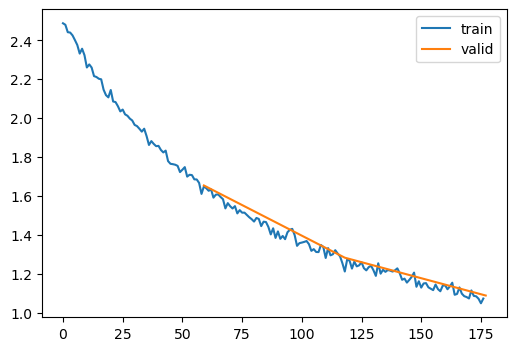

method is  <bound method MetricsCB.before_epoch of <miniai.learner.MetricsCB object at 0x0000025314B97F10>>
learn in  <__main__.Learner object at 0x0000025446BD2A60>
method is  <bound method ProgressCB.before_epoch of <miniai.learner.ProgressCB object at 0x0000025314384670>>
learn in  <__main__.Learner object at 0x0000025446BD2A60>
method is  <bound method DeviceCB.before_batch of <miniai.learner.DeviceCB object at 0x0000025314BA9EE0>>
learn in  <__main__.Learner object at 0x0000025446BD2A60>
method is  <bound method TrainCB.predict of <__main__.SGDCallback_TrainCB object at 0x0000025305198940>>
learn in  <__main__.Learner object at 0x0000025446BD2A60>
method is  <bound method TrainCB.get_loss of <__main__.SGDCallback_TrainCB object at 0x0000025305198940>>
learn in  <__main__.Learner object at 0x0000025446BD2A60>
method is  <bound method TrainCB.backward of <__main__.SGDCallback_TrainCB object at 0x0000025305198940>>
learn in  <__main__.Learner object at 0x0000025446BD2A60>
method is  

In [ ]:
#| echo: True
#| output: True

# Training with SGD as the optimizer
set_seed(42)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = Learner(model, dls, F.cross_entropy, cbs=cbs)
learn.fit(3)

## Adam with annealing

In [ ]:
#| echo: True
#| output: True

class AdamWithAnnealingCallback(TrainCB):
    def __init__(self, lr, wd=0., beta1=0.9, beta2=0.99, eps=1e-5, anneal_rate=0.97, n_inp=1):
        self.lr, self.wd, self.beta1, self.beta2, self.eps = lr, wd, beta1, beta2, eps
        self.anneal_rate = anneal_rate, self.n_inp = n_inp


    def step(self, learn):
        # calls torch.no_grad() to disable gradient tracking
        with torch.no_grad():
            # iterates over the parameters
            for p in learn.model.parameters():
                self.reg_step(p)
                self.opt_step(p)
        self.i +=1

    def reg_step(self, p):
         if self.wd != 0: p *= 1 - self.lr*self.wd

    def opt_step(self, p):



        if not hasattr(p, 'avg'): # Checks avg tensor doesnt exist in p
          p.avg = torch.zeros_like(p.grad.data) # creates a matching size tensor of all parameters to store averages, they will all be zeros.
        if not hasattr(p, 'sqr_avg'): # checks sqr_avg doesnt exist in p
          p.sqr_avg = torch.zeros_like(p.grad.data)  # creates a matching sized tensor of all parameters to store sqr averages, they will all be zeros.

        # A break down on the formulas for the Adam Optimizer

        # p.avg is to store the averages, it can be thought of as a balance between the old gradients and the new gradiants
        # Beta is set between 1 or 0, when its closer to 1 it takes more of the historical gradients into account and when close to 0, it takes the new gradients into account.
        # When its closer to 1, it will be a smoother path and when its zero it will respond to changes in gradients much quicker and appear more erratic.

        # Note, on the first run the calculation of p.avg is solely based on the latter part of the equation "(1 - self.beta1) * p.grad".
        # The first part of the equation "self.beta1 * p.avg" is zero meaning due to p.avg being set to zeros in the line "p.avg = torch.zeros_like(p.grad.data)".
        # The next time opt_step is called, The first part of the equation will influence the result "self.beta1 * p.avg".
        p.avg = self.beta1 * p.avg + (1 - self.beta1) * p.grad

        # Unbias_avg purpose is to correct p.avg for the first few times called. Remember that in the previous step, the p.avg is zero so isnt included in the calculations.
        # The unbias will  is more significant for the early iterations and gradually becomes less significant for later iterations.
        unbias_avg = p.avg / (1 - (self.beta1**(self.i + 1)))

        # Squaring the gradients (p.grad**2) emphasizes larger gradients and diminishes the impact of smaller ones.
        p.sqr_avg = self.beta2 * p.sqr_avg + (1 - self.beta2) * (p.grad**2)

        # unbias_sqr_avg purpose is to correct p.sqr_avg for the first few times called. Remember that in the previous step, the p.sqr_avg is zero so isnt included in the calculations.
        # The unbias will  is more significant for the early iterations and gradually becomes less significant for later iterations.
        unbias_sqr_avg = p.sqr_avg / (1 - (self.beta2**(self.i + 1)))

        # reduces the learning rate with each run by the annealing rate
        annealed_lr = self.lr * (self.anneal_rate ** self.i)

        # Update parameters
        p -= annealed_lr * unbias_avg / (unbias_sqr_avg.sqrt() + self.eps)

    # Calculates the weight decay and updates the parameters
    # The purpose of weight decay is to prevent overfitting. It is calculated by multiplying the learning rate by the weight decay
    # essentially it is a penalty for having large weights (it reduces the value of the weights)

    def zero_grad(self, learn): learn.opt.zero_grad()

In [ ]:
#| echo: True
#| output: True

# runs the learning rate finder

class AdamWithAnnealingCallback(Callback):
    def __init__(self, lr, wd=0., beta1=0.9, beta2=0.99, eps=1e-5, anneal_rate=0.97):
        self.lr, self.wd, self.beta1, self.beta2, self.eps = lr, wd, beta1, beta2, eps
        self.anneal_rate = anneal_rate
        """
        Custom callback class for Adam optimizer with annealing.
        Args:
        - lr: Learning rate.
        - wd: Weight decay (default: 0.).
        - beta1: Coefficient for the exponential moving average of the gradient (default: 0.9).
        - beta2: Coefficient for the exponential moving average of the squared gradient (default: 0.99).
        - eps: Small value added to the denominator for numerical stability (default: 1e-5).
        - anneal_rate: Annealing rate for the learning rate (default: 0.97).
        """

    def before_batch(self):
        """
        Prepare optimizer parameters before each batch.
        This method is called before each batch during training to prepare the optimizer parameters.
        It initializes the `opt_params` attribute with a list of dictionaries, where each dictionary
        contains the 'avg' and 'sqr_avg' tensors for the gradients of the model parameters.

        Returns:
            None
        """
        if self.training:
            self.opt_params = [{'avg': torch.zeros_like(p.grad.data), 'sqr_avg': torch.zeros_like(p.grad.data)}
                                if not hasattr(p, 'avg') else p.avg for p in self.learn.model.parameters()]

    def after_backward(self):
        """
        Performs the necessary computations and updates the model parameters after the backward pass.
        This method implements the Adam optimizer update rule for each parameter of the model.
        Returns:
            None
        """
        for p, opt_param in zip(self.learn.model.parameters(), self.opt_params):
            opt_param['avg'] = self.beta1 * opt_param['avg'] + (1 - self.beta1) * p.grad
            unbias_avg = opt_param['avg'] / (1 - (self.beta1 ** (self.n_iter + 1)))
            opt_param['sqr_avg'] = self.beta2 * opt_param['sqr_avg'] + (1 - self.beta2) * (p.grad ** 2)
            unbias_sqr_avg = opt_param['sqr_avg'] / (1 - (self.beta2 ** (self.n_iter + 1)))
            annealed_lr = self.lr * (self.anneal_rate ** self.n_iter)
            p.data -= annealed_lr * unbias_avg / (unbias_sqr_avg.sqrt() + self.eps)


In [ ]:
#| echo: True
#| output: True

metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(fc.risinstance(GeneralRelu))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats, AdamWithAnnealingCallback(lr=6e-3)]
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
iw = partial(init_weights, leaky=0.1)


TypeError: cannot unpack non-iterable int object

In [ ]:
#| echo: True
#| output: True

# Training with SGD as the optimizer
set_seed(42)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = Learner(model, dls, F.cross_entropy, cbs=cbs)
learn.fit(3)

method is  <bound method DeviceCB.before_fit of <miniai.learner.DeviceCB object at 0x0000025355822C70>>
learn in  <__main__.Learner object at 0x000002531DB4C1F0>
method is  <bound method MetricsCB.before_fit of <miniai.learner.MetricsCB object at 0x0000025444393C10>>
learn in  <__main__.Learner object at 0x000002531DB4C1F0>
method is  <bound method HooksCallback.before_fit of <miniai.activations.ActivationStats object at 0x0000025355822490>>
learn in  <__main__.Learner object at 0x000002531DB4C1F0>
method is  <bound method ProgressCB.before_fit of <miniai.learner.ProgressCB object at 0x0000025444294940>>
learn in  <__main__.Learner object at 0x000002531DB4C1F0>


method is  <bound method MetricsCB.before_epoch of <miniai.learner.MetricsCB object at 0x0000025444393C10>>
learn in  <__main__.Learner object at 0x000002531DB4C1F0>
method is  <bound method ProgressCB.before_epoch of <miniai.learner.ProgressCB object at 0x0000025444294940>>
learn in  <__main__.Learner object at 0x000002531DB4C1F0>


method is  <bound method DeviceCB.before_batch of <miniai.learner.DeviceCB object at 0x0000025355822C70>>
learn in  <__main__.Learner object at 0x000002531DB4C1F0>
method is  <bound method TrainCB.predict of <__main__.AdamWithAnnealingCallback object at 0x000002531DB012B0>>
learn in  <__main__.Learner object at 0x000002531DB4C1F0>


AttributeError: 'AdamWithAnnealingCallback' object has no attribute 'n_inp'

In [ ]:
#| echo: True
#| output: True

model

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): GeneralRelu()
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): GeneralRelu()
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): GeneralRelu()
  )
  (3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): GeneralRelu()
  )
  (4): Sequential(
    (0): Conv2d(64, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  )
  (5): Flatten(start_dim=1, end_dim=-1)
)

In [ ]:
#| echo: False
#| output: False

# look at this chat for more inforamtion
# https://chat.openai.com/c/6e02c7b8-363e-4fcd-b60d-6a41020d825d
# See for reference on callbacks C:\temp\resolver101757\posts\initialization_neural_networks\index.ipynb


In [ ]:
#| echo: True
#| output: True

# Training with SGD as the optimizer
set_seed(42)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=6e-3, cbs=cbs, opt_func=AdamWithAnnealing)
learn.fit(3)

AttributeError: learn